## Using GSKY to replace datacube

### This notebook will demonstrate the use of GSKY to retrieve and display landsat data.

##### Example 3

The requested bounding box is plotted as in example 2. Then, all invalid pixels (NaN) are identified and plotted as a separate map.

Instead of writing the GSKY output into a NetCDF file and then reading it back into Xarray, this example uses the **diskless** NetCDF that eliminates the disk I/O. Though it is quite unnecessary to do so in a single datafile situation, it is nevertheless given here to demonstrate the capability.

The data is in **netCDF4.\_netCDF4.Dataset** format. 

###### Specifics

- Converting a DEA notebook example to use GSKY instaed of datacube.

- Uses WCS to get an area from a specified layer/date/bbox/time, and differs from the DEA example.
    -- where an area around a single point is calculated.

- This example can only use one sensor ("ls8") instead of three sensors as DEA has used.

- The required area is specified a tile from a list that shows the bounding boxes. 

- If you can determine a valid BBox for a date (Tip: Use TerriaMap) it can be manually typed in.

- Only one time slice can be used in WCS. 
    - You can choose from all available times in the layer.
    
- The DEA example, using datacube, can get the data for a time range. It is not possible in GSKY.

**Author:** Arapaut V. Sivaprasad

**Date:** 11 February, 2020

### How to use

Use this notebook to display a GSKY layer corresponding to a time slice and bounding box (BBox). Instead of manually typing in the BBox, you can select a tile by its ID (e.g. 8_-31).

- Specify the name of layer in cell 2
    - layer = "landsat8_nbar_16day"
    - If necessary, uncomment its code block to see all available layers.

- Identify the available time positions (dates of data acquisitions) in cell 3
    - Give m,n values to display the range of dates (from 0 to n_times-1)
    - Give t=i to say which date to use, where i = 0 to n_times-1.

- Identify the tile ID in cell 4

- Specify the tile ID in cell 5
    - If you know another BBox with data (Tip: use TerriaMap to find) then type it in as a tuple:
        - bbox = (130.00, -27.00, 131.00, -29.00)

- Execute all cells from top to bottom.

In [2]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 18/10/2019; Last Modified: 11/02/2020  #
##########################################################
# Import all the required modules

from owslib.wcs import WebCoverageService
from netCDF4 import Dataset
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import logging, sys
logging.disable(sys.maxsize)


#### Specify the GSKY capabilities end URL is below. It must be one that you can access. 

There are several GSKY layers in the dataset. You must select one layer to view the data. By uncommenting its code you can display all available layers. Not all layers will have data for all time slices. A safe bet to see data is by choosing the layer, 'landsat8_nbar_16day'.

In [3]:
# Specify the GSKY production URL here. The layer is hard coded
gsky_url = 'https://gsky.nci.org.au/ows/dea'
layer = "landsat8_nbar_16day"
wcs = WebCoverageService(gsky_url, version='1.0.0')

# Uncomment below to see all layers.
#for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')

#### A time slice must be specified to show the layer. 

To help identify a time slice, specify the start and end values as m,n below, which will show the time slices in that range. Then specify the time slice as 't = i', where i = 0 to n_times-1

In [4]:
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times-1

# The time slice whose data is to be displayed is specified below. 
t = n-4

# Uncomment below to see all available times.
#print ("Total of", n_times,'timepositions:\n\n', time[m:n])


#### The Australian continent is divided into approximately 1x1 degree tiles, from -22 to +27 longitude degrees, and -8 to -36 latitude degrees on either side of a line through the centre of Australia. 

The ID and BBox for each tile will be generated in the next box. Choose a tile by its ID to display the layer.


In [5]:
tiles_list = {}
with open("tiles_bboxes.txt") as f:
    for line in f:
        (key, val) = line.split()
        tiles_list[str(key)] = val

# Uncomment below to see all tiles and ther BBoxes
#tiles_list

#### You must select a tile to get its BBox, after verifying that the tile has some data for the chosen layer and time.

Give a single tile as **" tiles = \['-11_-38'\]**. The BBox will be taken from this tile and scaled to fit the plot. The final output will be slightly larger than the original BBox.

In [6]:
tiles = ['1_-31']
bbox = [tiles_list[tiles[0]]]
x = float(bbox[0][0:6])
y = float(bbox[0][7:13])
X = float(bbox[0][14:20])
Y = float(bbox[0][21:27])
X = float('%.2f'%(x + ((abs(Y - y) / 220) * 340)))
bbox = (x,y,X,Y)

# If you know a BBox containing data (Tip: use TerriaMap to find out) then type it in below.
#bbox = ('130.00,-27.00,131.00,-29.00')

bbox

(133.03, -27.64, 134.42, -28.54)

#### A call is made to the GSKY server to get the data.

In [7]:
# Construct the URL for a WCS call and send it to the GSKY server.
# Style can be False Color (fc) or True Color (tc)
# This NB uses only NetCDF and EPSG:4326. Hence, do not change these.
# If any error, the displayed URL below can be opened in a browser to see the actual error message.
output = wcs.getCoverage(identifier=layer, Styles='tc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)

# Read the output into diskless NetCDF
nc = Dataset('dtemp.nc','r',diskless=True,persist=False, memory=output.read())
print(output.geturl())

http://gsky.nci.org.au/ows/dea?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=133.03%2C-27.64%2C134.42%2C-28.54&time=2019-10-17T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=tc


### Plot the bands together

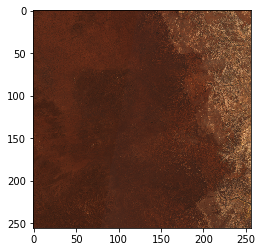

In [8]:
red = nc.variables['Band1'][:]
green = nc.variables['Band2'][:]
blue = nc.variables['Band3'][:]

# Stack the three bands together and cast it as float32
# In the line below the 'axis=2' ensures that the data shape is 256,256,3

# rgb = np.stack([nc.variables['Band%d' % (b+1)] for b in range(3)], axis=2).astype(np.float32)
rgb = np.stack([red, green, blue], axis=2).astype(np.float32)

# Convert all values into a range from 0 to 1. This is important.
rgb /= rgb.max()

# Uncomment to see the data values.
# print(rgb)

# Plot it
imgplot = plt.imshow(rgb)
plt.show()


### Identify valid pixels

Here we choose a single band from the Landsat data, and test whether each pixel contains valid values using the function np.isfinite. This will give us a dataset that contains False for any invalid pixel, and True for any valid observation.

We will later use this to normalise our counts of snow to account for missing data.

<function matplotlib.pyplot.show(*args, **kw)>

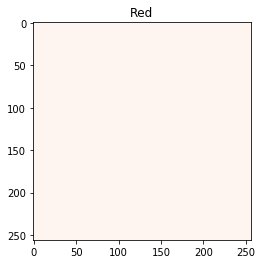

In [9]:
# Identify which pixels contain valid data in the Landsat dataset
valid_ds = np.isfinite(red)

# Plot one sample timestep from the `valid_ds` dataset. Red below represents
# invalid pixels, due to either issues with terrain shadow on steep mountains,
# cloud cover, snow accidently mapped as cloud, or gaps in Landsat overpasses.
# valid_ds.isel().plot(cmap='Reds_r')
plt.imshow(valid_ds, cmap='Reds')
plt.title('Red')
plt.show

`Copyright` &copy; `2019 by National Computational Infrastructure (NCI).`